In [2]:
import os, sys
ROOT = os.path.abspath("..")
sys.path.append(os.path.join(ROOT, "src"))
import numpy as np
import yaml
import gymnasium as gym
from gym_env.ref_env import Ref, make_env
from helpers import helper as h
from helpers import device as d
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

In [15]:
env_name = "C1_48"

In [16]:
C_path = f'env_config/discrete_joint/{env_name}.yaml'  # Default path for environment configuration
with open(f"{ROOT}/{C_path}", 'r') as f:
        env_cfg = yaml.load(f, Loader=yaml.SafeLoader)

env_params = env_cfg.copy()
project_name = env_params['env']['name']
delta_t = env_params['env']['time_step']          # Time step in hours
total_t = env_params['env']['Total_time']          # Total simulation time in hours
timelimit = int(np.ceil(total_t / delta_t))

In [17]:
n_seed = 20
n_ep = 30
start_seed = 0
save_dir = f"{ROOT}/results/{env_params['env']['name']}/{env_name}/test_data/DP_approximation"
os.makedirs(save_dir, exist_ok=True)
data_dir = f"{save_dir}/trajectories_0.csv"
info_dir = f"{save_dir}/info_0.txt"
delta_t =  env_params["env"]["time_step"]  # Time step in seconds
total_t =  env_params["env"]["Total_time"]  # Total time in seconds
timelimit = int(np.ceil(total_t / delta_t))  # Time limit in time steps
room_num =  env_params["rooms"]["num_rooms"] # Number of rooms in the facility
evap_num =  env_params["evaporators"]["num_evaps"] # Number of evaporators in the facility
group_num = len( env_params["sequencers"]["seq_list"]) # Number of groups in the facility
compressor_num = np.sum(np.asarray( env_params["compressors"]["num_compressors"])) # Number of compressors in the facility
price_num =  env_params["reward"]["price_num"] ### the length of the electricity price list as observation
action_type =  env_params["env"]["Action_type"]  # Type of action space (discrete or continuous)
action_space =  env_params["env"]["Action_space"]  # Number of action spaces (1 for all or 1 per room)
action_mode =  env_params["env"]["Action_mode"]  # "joint" or "separate" (joint: all actions together, separate: each action separately)
state_space =  env_params["env"]["state_space"]  # State space representation
min_room_temp = np.asarray( env_params["rooms"]["room_min_temp"])  # Minimum room temperature for violation
max_room_temp = np.asarray( env_params["rooms"]["room_max_temp"])  # Maximum room temperature for violation


In [18]:
Dp = np.load(f"{ROOT}/scripts/DP_results_150_old.npz")
pi = Dp['Pi_vi']
vi = Dp['V_vi']
N = 61
room_vals = np.linspace(-22.0, -15.9, num=N, dtype=np.float64)
V_MIN, V_MAX = float(room_vals[0]), float(room_vals[-1])
DX = (V_MAX - V_MIN) / (N - 1)

def value_to_index(x: float) -> int:
    idx = int(round((x - V_MIN) / DX))
    return int(np.clip(idx, 0, N - 1))
def snap2grid(x: float) -> float:
    return room_vals[value_to_index(x)]


def get_action (obs):

    room_temps = np.asarray(obs["room_temperatures"]).copy()
    i =  value_to_index(room_temps[0])
    j =  value_to_index(room_temps[1])
    
    return pi[i,j]
    # action = pi[i,j]
    # if action == 1:
    #     return 2
    # elif action == 2:
    #     return 1
    # else:
    #     return action




<Figure size 640x480 with 0 Axes>

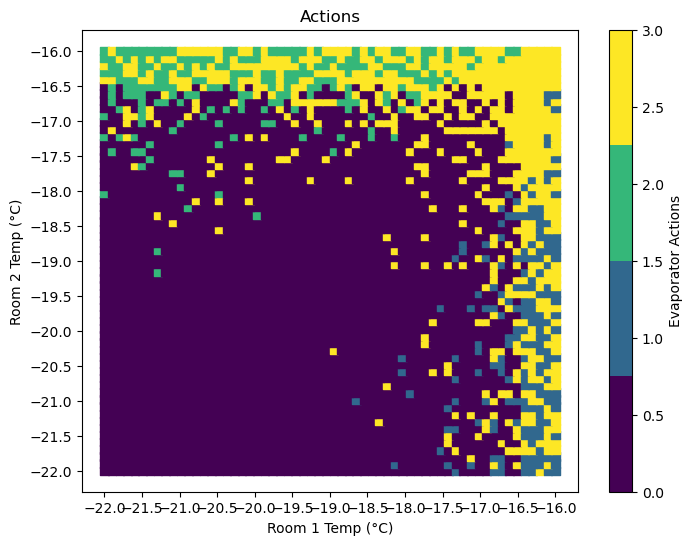

In [19]:
n = 60
room_1 = np.linspace(-22, -16, num=n, dtype=np.float64)
room_2 = np.linspace(-22, -16, num=n, dtype=np.float64)
mesh_x, mesh_y = np.meshgrid(room_1, room_2)
obs_array = np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1).astype(np.float64)
Ni = obs_array.shape[0]
obs_batch = {"room_temperatures": obs_array}
    
action_batch = np.zeros(shape=(Ni,), dtype=np.int32)
for i in range(Ni):

    obs = {"room_temperatures": obs_array[i, :]}
    action_batch[i] = get_action(obs)
action_grid = action_batch.reshape((n, n))

from matplotlib.colors import BoundaryNorm
plt.figure()
cmap = plt.get_cmap("viridis", 4)                # 4 discrete colors
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
color_map = plt.get_cmap("viridis", 4)  # 4 discrete colors for actions 0-3

plt.figure(figsize=(8, 6))
plt.scatter(mesh_x, mesh_y, c=action_grid[:, :], cmap=color_map, marker='s')
plt.colorbar(label="Evaporator Actions")
plt.title("Actions")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
plt.xticks(np.arange(-22, -15.5, 0.5))  
plt.yticks(np.arange(-22, -15.5, 0.5))
plt.show()






Text(0, 0.5, 'Room 2 Temp (°C)')

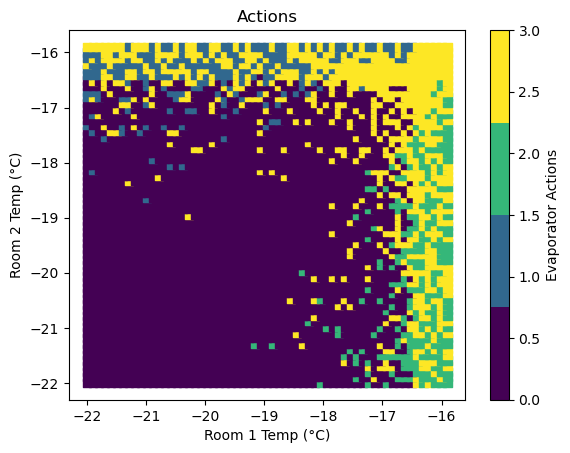

In [20]:
n_p = 61
room_1_p = np.linspace(-22, -15.9, num=n_p, dtype=np.float64)
room_2_p = np.linspace(-22, -15.9, num=n_p, dtype=np.float64)
mesh_x_p, mesh_y_p = np.meshgrid(room_1_p, room_2_p)

from matplotlib.colors import BoundaryNorm
plt.figure()
cmap = plt.get_cmap("viridis", 4)                # 4 discrete colors
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)


color_map = plt.get_cmap("viridis", 4)  # 4 discrete colors for actions 0-3
plt.scatter(mesh_x_p, mesh_y_p, c=pi[:, :], cmap=color_map, marker='s')
plt.colorbar(label="Evaporator Actions")
plt.title("Actions")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")

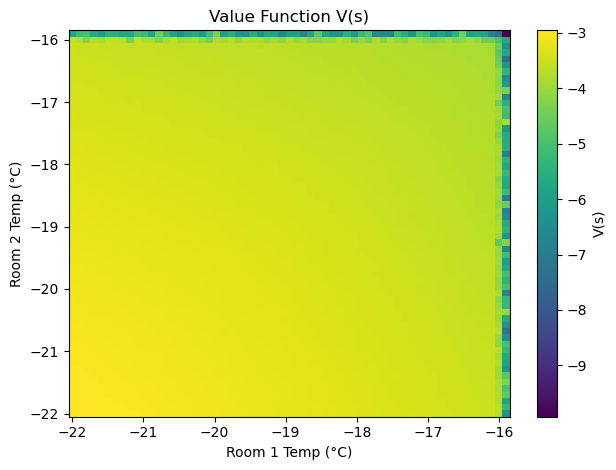

In [21]:

plt.figure()
plt.title("Value Function V(s)")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
# Use pcolormesh with the meshgrid for correct axes
plt.pcolormesh(mesh_x_p, mesh_y_p, vi, shading="auto")
plt.colorbar(label="V(s)")
# Optional: if you want -15 on the left/top visually:
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

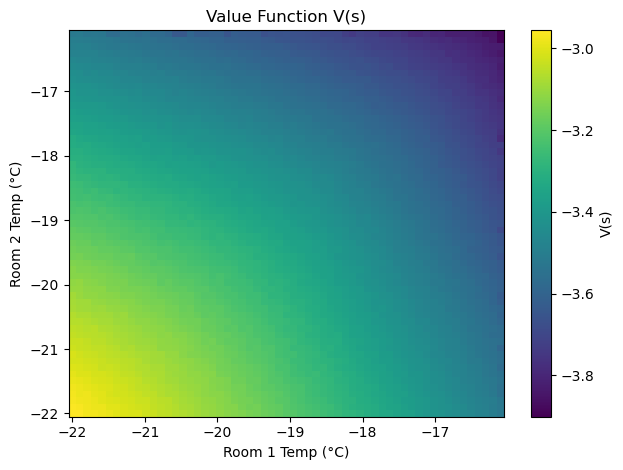

In [22]:
plt.figure()
plt.title("Value Function V(s)")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
t = 59
 
# take only the first 60 values along each axis
r = slice(0, t)
mesh_x_60 = mesh_x[r, r]
mesh_y_60 = mesh_y[r, r]
V_60      = vi[r, r]

plt.pcolormesh(mesh_x_60, mesh_y_60, V_60, shading="auto")
plt.colorbar(label="V(s)")

# If you want -15 on the left/top visually:
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [84]:
print(obs_batch["room_temperatures"].shape)
print(N)

(3600, 2)
61


In [23]:


save_dict = {}

##### room [ room_num, min_temp, max_temp ]

room_temps = np.zeros(shape=( n_seed,  n_ep,  room_num,  timelimit+1))


Q_dist = np.zeros(shape=( n_seed,  n_ep,  room_num,  timelimit+1))
save_dict["Q_dist"] = Q_dist


is_violated = np.zeros(shape=( n_seed,  n_ep,  room_num,  timelimit+1 , 2), dtype=bool)
save_dict["is_violated"] = is_violated

##### evaporator [ evap_num ]
if "evaporator_utilization" in  state_space or  env_params["evaporators"]["util_constraint"] != None:
    on_off_util = np.zeros(shape=( n_seed,  n_ep,  evap_num,  timelimit+1))
    save_dict["on_off_util"] = on_off_util

if "evaporator_on_time" in  state_space or  env_params["evaporators"]["on_off_min_constraint"] != None :
    on_time = np.zeros(shape=( n_seed,  n_ep,  evap_num,  timelimit+1))
    save_dict["on_time"] = on_time

if "evaporator_off_time" in  state_space or  env_params["evaporators"]["on_off_min_constraint"] != None :
    off_time = np.zeros(shape=( n_seed,  n_ep,  evap_num,  timelimit+1))
    save_dict["off_time"] = off_time

on_off = np.zeros(shape=( n_seed,  n_ep,  evap_num,  timelimit+1))
save_dict["on_off"] = on_off

Q_evap = np.zeros(shape=( n_seed,  n_ep,  evap_num,  timelimit+1))
save_dict["Q_evap"] = Q_evap

##### electricity price [ price_num ]
if "electricity_price_list" in  state_space:
    price_list = np.zeros(shape=( n_seed,  n_ep,  price_num,  timelimit))
    save_dict["price_list"] = price_list

if "EP_remaining" in  state_space:
    EP_remaining = np.zeros(shape=( n_seed,  n_ep,  price_num,  timelimit))
    save_dict["EP_remaining"] = EP_remaining

if "electricity_price" in  state_space:
    price = np.zeros(shape=( n_seed,  n_ep,  price_num,  timelimit))
    save_dict["price"] = price  

###### Sequencer [ group_num ]

T_suction = np.zeros(shape=( n_seed,  n_ep,  group_num,  timelimit+1))
save_dict["T_suction"] = T_suction

overloaded = np.zeros(shape=( n_seed,  n_ep,  group_num,  timelimit+1), dtype=bool)
save_dict["overloaded"] = overloaded


###### Compressors [ compressor_num ]

W_max = np.zeros(shape=( n_seed,  n_ep,  compressor_num,  timelimit+1))
save_dict["W_max"] = W_max

W = np.zeros(shape=( n_seed,  n_ep,  compressor_num,  timelimit+1))
save_dict["W"] = W

Q_max = np.zeros(shape=( n_seed,  n_ep,  compressor_num,  timelimit+1))
save_dict["Q_max"] = Q_max

Q_max_clipped = np.zeros(shape=( n_seed,  n_ep,  compressor_num,  timelimit+1))
save_dict["Q_max_clipped"] = Q_max_clipped

W_max_clipped = np.zeros(shape=( n_seed,  n_ep,  compressor_num,  timelimit+1))
save_dict["W_max_clipped"] = W_max_clipped

##### Reward and cost (one value per timestep)
compressor_cost = np.zeros(shape=( n_seed,  n_ep,  timelimit))
save_dict["compressor_cost"] = compressor_cost

violation_cost = np.zeros(shape=( n_seed,  n_ep,  timelimit))
save_dict["violation_cost"] = violation_cost

total_cost = np.zeros(shape=( n_seed,  n_ep,  timelimit))
save_dict["total_cost"] = total_cost

#### One value per episode
ep_cost = np.zeros(shape=( n_seed,  n_ep))
save_dict["ep_cost"] = ep_cost




############ Run the episodes and collect data for RL! ############
env = Monitor(gym.wrappers.TimeLimit(Ref(params= env_params), max_episode_steps= timelimit))
for seed in range( start_seed,  start_seed +  n_seed):
    
    for ep in range( n_ep):
        t = 0
        obs, info = env.reset (seed = 100*seed + ep)
        terminated, truncated = False, False

        #### Room info
        room_temps[seed, ep, :, t] = obs["room_temperatures"]
        is_violated[seed, ep, :, t ,  0] = (room_temps[seed, ep, :, t] >  max_room_temp[:])
        is_violated[seed, ep, :, t ,  1] = (room_temps[seed, ep, :, t] <  min_room_temp[:])
        Q_dist[seed, ep, :, t] = info["Q_dist"]

        ### Evaporator info
        if "evaporator_utilization" in  state_space:
            on_off_util[seed, ep, :, t] = obs["evaporator_utilization"]
        if "evaporator_on_time" in  state_space:
            on_time[seed, ep, :, t] = obs["evaporator_on_time"]
        if "evaporator_off_time" in  state_space:
            off_time[seed, ep, :, t] = obs["evaporator_off_time"]

        on_off[seed, ep, :, t] = info["evaporator_status"]
        Q_evap[seed, ep, :, t] = info["Q_evap"]
        
        #### Compressor info
        W_max[seed, ep,: , t] = info["W_max"]
        W[seed, ep, :, t] = info["compressor_power"]
        Q_max[seed, ep, :, t] = info["Q_max"]
        W_max_clipped[seed, ep, :, t] = info["W_max_clip"]
        Q_max_clipped[seed, ep, :, t] = info["Q_max_clip"]
        
        # group info 
        T_suction[seed, ep, :, t] = info["T_suction"]
        overloaded[seed, ep, :, t] = info["overloaded"]

        

        while not (terminated or truncated):
            t += 1
            action = get_action(obs)
            obs, total_cost[seed, ep, t-1], terminated, truncated, info = env.step(action)

            #### Room info
            room_temps[seed, ep, :, t] = obs["room_temperatures"]
            is_violated[seed, ep, :, t ,  0] = (room_temps[seed, ep, :, t] >  max_room_temp[:])
            is_violated[seed, ep, :, t ,  1] = (room_temps[seed, ep, :, t] <  min_room_temp[:])
            Q_dist[seed, ep, :, t] = info["Q_dist"]


            #### Evaporator info
            on_off[seed, ep, :, t] = info["evaporator_status"]
            Q_evap[seed, ep, :, t] = info["Q_evap"]
            if "evaporator_utilization" in  state_space:
                on_off_util[seed, ep, :, t] = obs["evaporator_utilization"]
            if "evaporator_on_time" in  state_space:
                on_time[seed, ep, :, t] = obs["evaporator_on_time"]
            if "evaporator_off_time" in  state_space:
                off_time[seed, ep, :, t] = obs["evaporator_off_time"]
            
            
            #### Compressor info
            W_max[seed, ep, : , t] = info["W_max"]
            W[seed, ep, :, t] = info["compressor_power"]
            Q_max[seed, ep, :, t] = info["Q_max"]
            W_max_clipped[seed, ep, :, t] = info["W_max_clip"]
            Q_max_clipped[seed, ep, :, t] = info["Q_max_clip"]

            # group info
            T_suction[seed, ep, :, t] = info["T_suction"]
            overloaded[seed, ep, :, t] = info["overloaded"]

            #### E_price info 
            if "electricity_price_list" in  state_space:
                price_list[seed, ep, :, t-1] = obs["electricity_price_list"]
                

            if "EP_remaining" in  state_space:
                EP_remaining[seed, ep, :, t-1] = obs["EP_remaining"]

            if "electricity_price" in  state_space:
                price[seed, ep, :, t-1] = obs["electricity_price"]

            # cost info
            compressor_cost[seed, ep, t-1] = info["compressor_cost"]
            violation_cost[seed, ep, t-1] = info["violations_cost"] 

            ep_cost[seed, ep] += (total_cost[seed, ep, t-1])  # Total cost for the episode 

env.close()

mean_reward = np.mean(ep_cost) #Avg reward
std_reward = np.std(ep_cost) #Std reward (not really reliable)
violation_num = np.sum(is_violated[:, :, :, : ,:], axis=(0, 1, 3)) #Number of violations for each room
on_time = np.mean(on_off[:, :, :, :] > 0, axis=(0, 1, 3)) #Average on time for each room (fan speed!)
off_time = np.sum(on_off[:, :, :, :] == 0, axis=(0, 1, 3)) #Total off time for each room
Avg_room_temp = np.mean(room_temps[:, :, :, :], axis=(0, 1, 3)) #Average room temperature for each room


numpy_dir =  data_dir.replace(".csv", ".npz")
##### Save result in numpy and compress
np.savez_compressed(numpy_dir, **{key: save_dict[key] for key in save_dict})

with open( info_dir, "w") as f:
            f.write(f"Policy name: DP\n")
            f.write(f"Number of episodes: { n_ep}\n")
            f.write(f"Number of seeds: { n_seed}\n")
            f.write(f"Start seed: { start_seed}\n")
            f.write(f"Environment parameters:\n")
            for key, value in  env_params.items():
                f.write(f"{key}: {value}\n")

            f.write(f"Evaluation results:\n")
            f.write(f"Mean reward over { n_seed* n_ep} episodes: {mean_reward}\n")
            f.write(f"Std reward over { n_seed* n_ep} episodes: {std_reward}\n")
            f.write(f"Violation number for each room over { n_seed* n_ep} episodes: {violation_num}\n")
            f.write(f"Average on time for each evaporator over { n_seed* n_ep} episodes: {np.asarray(on_time)*100}\n")
            f.write(f"Total off time for each evaporator over { n_seed* n_ep} episodes: {off_time}\n")
            f.write(f"Average room temperature for each room over { n_seed* n_ep} episodes: {Avg_room_temp}\n")



In [86]:
print(total_cost.shape)

(1, 1, 1440)


In [87]:
print(np.sum(total_cost))

-55.482777637987304


In [88]:
print(np.sum(violation_cost)*60)

0.0


In [89]:
print(np.sum(compressor_cost)*60)

55.482777637987304


In [90]:
print(violation_cost.shape)
print(compressor_cost.shape)

(1, 1, 1440)
(1, 1, 1440)
